<a href="https://colab.research.google.com/github/WRFitch/fyp/blob/main/src/fyp_model_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing
A notebook for testing an exported model. Ideally, this can be considered a part of a model evaluation pipeline, in which a model can be evaluated in greater depth. 

## Setup

### Notebook Setup 

In [ ]:
!pip uninstall -y fastai
!pip install -U --no-cache-dir fastai

In [ ]:
from fastai.vision.all import *
from google.colab import drive
#from scipy import stats
from sklearn.metrics import mean_squared_error

import numpy as np 
import os 
import pandas as pd

drive.mount('/content/drive')

In [ ]:
%rm -rf /content/fyp/

In [ ]:
# Import fyputil library
%cd /content
!git clone https://github.com/WRFitch/fyp.git
%cd fyp/src/fyputil
import constants as c
import fyp_utils as fyputil
%cd /content

### Data Setup 

In [3]:
# Add a dummy label script to fool fastai into letting us import the model. 
# We're not going to train the model further, so this is fine. 
def getGhgsAsArr(img_path):
  return np.array()

model = load_learner(f"{c.model_dir}/mrghg_fullnorm.pkl")

def normGhgDf(ghg_df):
  for band in c.ghg_bands:
    max = ghg_df[band].max()
    min = ghg_df[band].min()
    ghg_df[band] = ghg_df[band].apply(lambda x: (x-min)/(max-min) * 100)
  return ghg_df


In [ ]:
ghg_df = pd.read_csv(c.ghg_csv)
ghg_df = normGhgDf(ghg_df)
ghg_df

In [ ]:
err_headers = [c.lon, c.lat] + c.ghg_bands
errors = pd.DataFrame(columns = err_headers)
errors.iloc[0:1]

## Testing

### Test model against existing data 

In [6]:
print(c.ghg_bands)

# TODO replace with fyputil, OR re-implement to keep any failed measurements and
# evaluate what you can out of them. Just because they're incomplete, that 
# doesn't necessarily make them worthless 
def getGhgs(img_path, df): 
  coords = fyputil.getCoords(str(img_path))
  ghgs = fyputil.getValAt(coords, df)
  concentrations = ghgs[c.ghg_bands]
  if len(concentrations) == 0 : return None 
  if None in concentrations: return None
  # There has to be a cleaner way to do this. Iterating through and then only getting the first line? really? 
  return [tuple(x) for x in concentrations.to_numpy()][0]

['CO_column_number_density', 'tropospheric_HCHO_column_number_density', 'tropospheric_NO2_column_number_density', 'O3_column_number_density', 'SO2_column_number_density', 'CH4_column_volume_mixing_ratio_dry_air']


In [ ]:
# Dumb & easy method of splitting data so I don't have to analyse every image 
# every time I want to smell test something. 
mod = 0 

for filename in os.listdir(c.png_dir):
  file_ghgs = getGhgs(filename, ghg_df)
  if file_ghgs == None: continue
  if mod % 1 == 0:
    print(f"predicting ghg gases at {filename}")
    coords = fyputil.getCoords(filename) 
    prediction = model.predict(f"{c.png_dir}/{filename}")[0]

    diffs = [pred - act for pred, act in zip(prediction, file_ghgs)]
    errors.loc[len(errors)] = list(coords) + diffs

    print(tuple(coords))
    print(prediction)
    print(file_ghgs)
    print(diffs)
    print()
  mod += 1 



In [ ]:
errors 

In [ ]:
errors.to_csv(f"{c.data_dir}/errors_norm.csv")

### Basic stat testing 
- Data exploration 
- RMSE per GHG
- Extract outliers & view images 

In [7]:
errors = pd.read_csv(f"{c.data_dir}/errors_norm.csv")

In [8]:
model_stats = pd.DataFrame(columns = ["stat"] + c.ghg_bands)

In [9]:
def getRmse(series): 
  return np.sqrt(np.mean(series**2))

In [10]:
# Define aggregate metrics 
# TODO remove multiple iterations through errors, improve bigO 
means = [errors[ghg].mean() for ghg in c.ghg_bands ]
stdevs = [errors[ghg].std() for ghg in c.ghg_bands ]
rmse = [getRmse(errors[ghg]) for ghg in c.ghg_bands ]
mae = [errors[ghg].abs().mean() for ghg in c.ghg_bands ]

model_stats.loc[1] = ["Mean"] + means
model_stats.loc[2] = ["Standard Deviation"] + stdevs 
model_stats.loc[3] = ["RMSE"] + rmse
model_stats.loc[4] = ["MAE"] + mae

In [11]:
model_stats

,stat,CO_column_number_density,tropospheric_HCHO_column_number_density,tropospheric_NO2_column_number_density,O3_column_number_density,SO2_column_number_density,CH4_column_volume_mixing_ratio_dry_air
1,Mean,-0.401066,-0.225506,-1.252926,0.867189,0.756036,-1.342584
2,Standard Deviation,15.109546,16.993505,16.255879,14.428115,16.041854,14.710859
3,RMSE,15.110863,16.990496,16.299795,14.450333,16.055411,14.768113
4,MAE,11.774294,13.157876,12.878742,10.546847,12.489943,11.338034


#### Plot raw stats 

In [115]:
# Merge ghg and recalculate predictions 
errcols = [f"{ghg}_err" for ghg in c.ghg_bands]
combi_df = ghg_df.merge(errors, how="inner", on=[c.lon, c.lat], suffixes=("_orig", "_err"))
for ghg in c.ghg_bands:
  combi_df[f"{ghg}_pred"] = combi_df[f"{ghg}_orig"] + combi_df[f"{ghg}_err"]

combi_df["errsum"] = combi_df[errcols].sum(axis=1)
combi_df["errabs"] = combi_df[errcols].abs().sum(axis=1)

In [13]:
combi_df

,Unnamed: 0_orig,system:index,SO2_column_number_density_orig,longitude,latitude,CH4_column_volume_mixing_ratio_dry_air_orig,CO_column_number_density_orig,tropospheric_HCHO_column_number_density_orig,tropospheric_NO2_column_number_density_orig,O3_column_number_density_orig,Unnamed: 0_err,CO_column_number_density_err,tropospheric_HCHO_column_number_density_err,tropospheric_NO2_column_number_density_err,O3_column_number_density_err,SO2_column_number_density_err,CH4_column_volume_mixing_ratio_dry_air_err,CO_column_number_density_pred,tropospheric_HCHO_column_number_density_pred,tropospheric_NO2_column_number_density_pred,O3_column_number_density_pred,SO2_column_number_density_pred,CH4_column_volume_mixing_ratio_dry_air_pred
0,134,0_134,37.059645,-0.795009,51.118631,19.607470,33.377361,6.603347,4.773004,15.388263,612,5.968124,40.289491,24.345281,31.920808,16.882917,12.773931,39.345486,46.892838,29.118284,47.309071,53.942562,32.381401
1,135,0_135,32.874369,-0.786026,51.118631,18.383528,30.641076,8.903884,5.345012,14.434940,613,4.245803,36.717717,15.314325,25.018548,24.315191,10.883625,34.886879,45.621601,20.659336,39.453487,57.189560,29.267153
2,136,0_136,38.575800,-0.777043,51.118631,16.526009,32.553934,6.237494,3.764341,9.809938,614,-2.141455,36.598569,13.467890,32.588237,14.532522,12.669729,30.412479,42.836063,17.232231,42.398174,53.108322,29.195738
3,137,0_137,46.757106,-0.768060,51.118631,8.346549,31.724441,4.383772,3.134054,5.152530,615,-3.510448,38.654524,14.326038,34.605287,7.845196,17.202994,28.213993,43.038296,17.460093,39.757816,54.602303,25.549543
4,138,0_138,48.375586,-0.759076,51.118631,13.259975,29.757876,9.120335,3.250394,4.019683,616,5.051507,34.220832,26.092887,44.938801,-0.653327,11.681185,34.809383,43.341167,29.343281,48.958485,47.722260,24.941160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,4147,0_4147,28.982110,0.345851,51.379143,48.730023,51.676159,40.240712,52.492478,82.988492,410,17.283146,6.853896,-1.665936,-2.422917,10.477576,14.635924,68.959305,47.094608,50.826542,80.565575,39.459686,63.365948
1882,4148,0_4148,29.317961,0.354835,51.379143,69.944322,55.563051,33.433213,51.374351,83.640236,412,8.201598,10.795058,-12.380695,-8.200912,15.780748,-10.598707,63.764648,44.228271,38.993656,75.439323,45.098709,59.345615
1883,4149,0_4149,32.202132,0.363818,51.379143,51.965457,67.081132,44.057710,52.922176,84.070751,411,0.863662,0.794280,-6.179100,-4.888554,9.545274,10.907193,67.944794,44.851990,46.743076,79.182198,41.747406,62.872650
1884,4150,0_4150,37.128438,0.372801,51.379143,51.965438,63.214312,47.319044,50.743240,82.580199,413,-1.665083,-1.693747,-16.465824,-9.008330,9.412170,4.617250,61.549229,45.625298,34.277416,73.571869,46.540607,56.582687


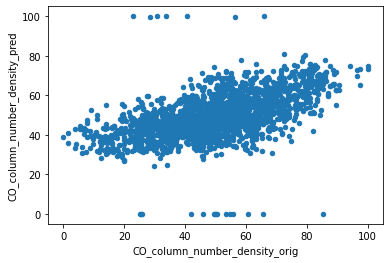

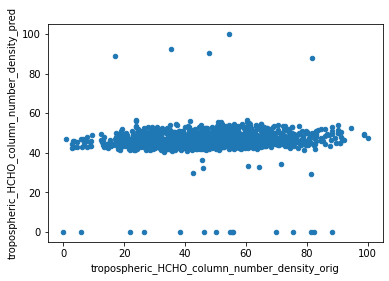

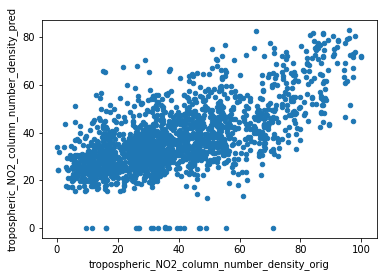

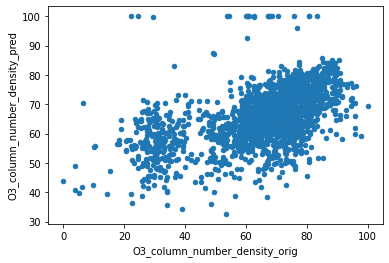

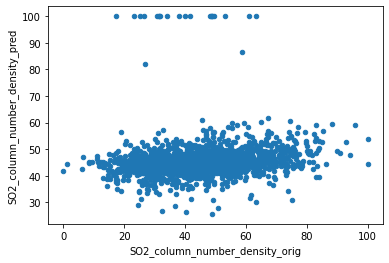

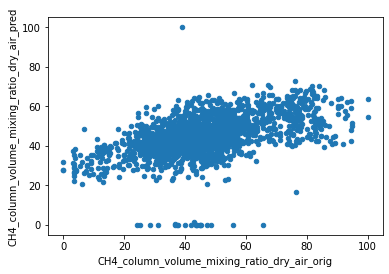

In [14]:
for ghg in c.ghg_bands:
  combi_df.plot(x = f"{ghg}_orig", y = f"{ghg}_pred", kind = "scatter")
  plt.show()

### Find and process Outliers 
- Percentile 
  - 1.5*IQR for weak outliers
  - 3*IQR for strong outliers
- Linear regression 
- Standard deviation +- 2 (or 3) 
- Normal probability plot 



In [ ]:
# Individual outlier bands 
outliers = []
for ghg in c.ghg_bands:
  ghg_outliers = []
  q1 = combi_df[f"{ghg}_err"].quantile(0.25)
  q3 = combi_df[f"{ghg}_err"].quantile(0.75)
  iqr = q3 - q1
  lbound = q1 - 1.5*iqr
  ubound = q3 + 1.5*iqr
  ghg_outliers = combi_df.loc[(combi_df[f"{ghg}_err"] < lbound) | (combi_df[f"{ghg}_err"] > ubound)]
  outliers.append(ghg_outliers)


In [111]:
all_outliers = pd.concat(outliers, join="inner").drop_duplicates()
all_outliers["errsum"] = all_outliers[errcols].abs().sum(axis=1)
all_outliers

,Unnamed: 0_orig,system:index,SO2_column_number_density_orig,longitude,latitude,CH4_column_volume_mixing_ratio_dry_air_orig,CO_column_number_density_orig,tropospheric_HCHO_column_number_density_orig,tropospheric_NO2_column_number_density_orig,O3_column_number_density_orig,Unnamed: 0_err,CO_column_number_density_err,tropospheric_HCHO_column_number_density_err,tropospheric_NO2_column_number_density_err,O3_column_number_density_err,SO2_column_number_density_err,CH4_column_volume_mixing_ratio_dry_air_err,CO_column_number_density_pred,tropospheric_HCHO_column_number_density_pred,tropospheric_NO2_column_number_density_pred,O3_column_number_density_pred,SO2_column_number_density_pred,CH4_column_volume_mixing_ratio_dry_air_pred,errsum
215,1077,0_1077,49.695449,-0.750093,51.181513,30.990776,40.836518,47.971628,11.429597,24.509229,420,59.163482,42.806600,-11.429597,75.490771,50.304421,-30.990776,100.000000,9.077823e+01,1.413163e-10,100.000000,99.999870,2.011119e-07,270.185647
216,1078,0_1078,53.193526,-0.741110,51.181513,28.455621,46.047262,38.370652,9.594400,22.358752,421,-46.047262,-38.370652,-9.594400,77.641248,46.806474,-28.455621,0.000000,0.000000e+00,1.776357e-15,100.000000,100.000000,-3.552714e-15,246.915658
330,1223,0_1223,58.864181,-0.642295,51.190496,36.643157,56.308378,46.084229,16.185608,29.374472,535,43.474176,-13.832753,-16.028499,70.451478,27.808403,-35.922859,99.782555,3.225148e+01,1.571090e-01,99.825951,86.672585,7.202976e-01,207.518169
354,1256,0_1256,48.841986,-0.345851,51.190496,43.503031,13.910328,64.418662,15.181725,49.285738,559,41.479546,-31.740039,21.677479,38.291906,-23.239628,-16.401824,55.389874,3.267862e+01,3.685920e+01,87.577644,25.602358,2.710121e+01,172.830421
607,1577,0_1577,61.000948,0.130256,51.208463,55.771287,65.685064,46.216596,33.248328,70.634996,882,-65.685064,-46.216596,-33.248328,29.365004,38.999052,-55.771287,0.000000,-7.105427e-15,0.000000e+00,100.000000,100.000000,0.000000e+00,269.285330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1617,3809,0_3809,23.828163,-0.282969,51.361176,85.649118,84.388491,44.727533,81.806150,85.060535,146,-34.550985,8.170672,-18.277399,-13.694484,20.346779,-46.040159,49.837505,5.289820e+01,6.352875e+01,71.366051,44.174942,3.960896e+01,141.080479
1620,3815,0_3815,51.735717,-0.229070,51.361176,88.633746,81.836762,48.226250,81.223002,87.776334,149,-30.916432,1.035210,-28.389506,-16.350370,-10.574917,-44.228400,50.920330,4.926146e+01,5.283350e+01,71.425964,41.160801,4.440535e+01,131.494834
1724,3946,0_3946,49.405258,-0.256020,51.370160,92.471157,79.425187,52.416825,84.893271,86.659233,253,-16.503800,0.659198,-12.358511,-5.411492,-12.556011,-38.500882,62.921387,5.307602e+01,7.253476e+01,81.247742,36.849247,5.397028e+01,85.989893
1725,3949,0_3949,47.682197,-0.229070,51.370160,100.000000,88.516681,51.783145,92.455466,87.701237,254,-22.687900,4.003678,-13.400755,-6.482266,-10.302593,-45.241905,65.828781,5.578682e+01,7.905471e+01,81.218971,37.379604,5.475809e+01,102.119097


In [93]:
errcols = [f"{ghg}_err" for ghg in c.ghg_bands]
multiple_outliers = pd.concat(outliers, join="inner")
multiple_outliers = multiple_outliers[multiple_outliers.duplicated()]
multiple_outliers = multiple_outliers.drop_duplicates()
multiple_outliers["errsum"] = multiple_outliers[errcols].abs().sum(axis=1)
multiple_outliers

,Unnamed: 0_orig,system:index,SO2_column_number_density_orig,longitude,latitude,CH4_column_volume_mixing_ratio_dry_air_orig,CO_column_number_density_orig,tropospheric_HCHO_column_number_density_orig,tropospheric_NO2_column_number_density_orig,O3_column_number_density_orig,Unnamed: 0_err,CO_column_number_density_err,tropospheric_HCHO_column_number_density_err,tropospheric_NO2_column_number_density_err,O3_column_number_density_err,SO2_column_number_density_err,CH4_column_volume_mixing_ratio_dry_air_err,CO_column_number_density_pred,tropospheric_HCHO_column_number_density_pred,tropospheric_NO2_column_number_density_pred,O3_column_number_density_pred,SO2_column_number_density_pred,CH4_column_volume_mixing_ratio_dry_air_pred
607,1577,0_1577,61.000948,0.130256,51.208463,55.771287,65.685064,46.216596,33.248328,70.634996,882,-65.685064,-46.216596,-33.248328,29.365004,38.999052,-55.771287,0.000000e+00,-7.105427e-15,0.000000e+00,100.000000,100.000000,0.000000e+00
915,2238,0_2238,63.182507,0.049407,51.253379,47.319849,42.109128,81.559135,30.765314,60.369447,1190,-42.109128,-81.559135,-30.765314,39.630553,36.817493,-47.319849,7.105427e-15,0.000000e+00,-3.552714e-15,100.000000,100.000000,0.000000e+00
997,2347,0_2347,34.261674,-0.175171,51.262362,39.097895,23.045680,55.708671,36.811794,68.054072,1830,76.954320,-55.708671,-36.811794,31.945928,65.738326,60.902105,1.000000e+02,0.000000e+00,0.000000e+00,100.000000,100.000000,1.000000e+02
1024,2377,0_2377,26.624319,0.094323,51.262362,43.798842,55.756790,69.764009,27.120010,61.163770,1860,-55.756790,-69.764009,-27.120010,38.836230,73.375681,-43.798842,-7.105427e-15,0.000000e+00,-3.552714e-15,100.000000,100.000000,0.000000e+00
1025,2378,0_2378,25.250247,0.103306,51.262362,43.708216,53.379702,75.518100,26.018579,60.824790,1861,-53.379702,-75.518100,-26.018579,39.175210,74.749753,-43.708216,-7.105427e-15,0.000000e+00,-3.552714e-15,100.000000,100.000000,0.000000e+00
1026,2379,0_2379,31.312287,0.112289,51.262362,39.862892,54.791077,88.298376,26.765533,60.067459,1862,-54.791077,-88.298376,-26.765533,39.932541,68.687713,-39.862892,0.000000e+00,0.000000e+00,0.000000e+00,100.000000,100.000000,0.000000e+00
1085,2860,0_2860,48.809571,-0.381784,51.298294,42.016314,49.601781,55.490133,40.588818,67.376911,1289,-49.601781,-55.490133,-40.588818,32.623089,51.190429,-42.016314,0.000000e+00,-7.105427e-15,0.000000e+00,100.000000,100.000000,0.000000e+00
1119,2902,0_2902,31.931226,-0.004492,51.298294,25.267247,30.774655,35.432072,35.579664,60.751422,1321,69.225345,57.347629,-35.579664,39.248578,68.068484,-25.267246,1.000000e+02,9.277970e+01,7.284271e-10,100.000000,99.999710,1.078917e-06
1208,3018,0_3018,31.605868,-0.166188,51.307277,36.841460,50.625875,50.092992,41.867676,80.829321,1412,-50.625875,-50.092992,-41.867676,19.170679,68.394132,-36.841460,-7.105427e-15,0.000000e+00,-7.105427e-15,100.000000,100.000000,-7.105427e-15
1850,4108,0_4108,17.404422,-0.004492,51.379143,37.660158,85.214232,82.376933,70.991385,80.764643,379,-85.214232,-82.376933,-70.991385,19.235357,82.595578,-37.660158,0.000000e+00,0.000000e+00,0.000000e+00,100.000000,100.000000,0.000000e+00


In [97]:
multiple_outliers.nlargest(10, ['errsum'])

,Unnamed: 0_orig,system:index,SO2_column_number_density_orig,longitude,latitude,CH4_column_volume_mixing_ratio_dry_air_orig,CO_column_number_density_orig,tropospheric_HCHO_column_number_density_orig,tropospheric_NO2_column_number_density_orig,O3_column_number_density_orig,Unnamed: 0_err,CO_column_number_density_err,tropospheric_HCHO_column_number_density_err,tropospheric_NO2_column_number_density_err,O3_column_number_density_err,SO2_column_number_density_err,CH4_column_volume_mixing_ratio_dry_air_err,CO_column_number_density_pred,tropospheric_HCHO_column_number_density_pred,tropospheric_NO2_column_number_density_pred,O3_column_number_density_pred,SO2_column_number_density_pred,CH4_column_volume_mixing_ratio_dry_air_pred,errsum
1850,4108,0_4108,17.404422,-0.004492,51.379143,37.660158,85.214232,82.376933,70.991385,80.764643,379,-85.214232,-82.376933,-70.991385,19.235357,82.595578,-37.660158,0.000000e+00,0.000000e+00,0.000000e+00,100.000000,100.000000,0.000000,378.073644
997,2347,0_2347,34.261674,-0.175171,51.262362,39.097895,23.045680,55.708671,36.811794,68.054072,1830,76.954320,-55.708671,-36.811794,31.945928,65.738326,60.902105,1.000000e+02,0.000000e+00,0.000000e+00,100.000000,100.000000,100.000000,328.061144
1026,2379,0_2379,31.312287,0.112289,51.262362,39.862892,54.791077,88.298376,26.765533,60.067459,1862,-54.791077,-88.298376,-26.765533,39.932541,68.687713,-39.862892,0.000000e+00,0.000000e+00,0.000000e+00,100.000000,100.000000,0.000000,318.338132
1025,2378,0_2378,25.250247,0.103306,51.262362,43.708216,53.379702,75.518100,26.018579,60.824790,1861,-53.379702,-75.518100,-26.018579,39.175210,74.749753,-43.708216,-7.105427e-15,0.000000e+00,-3.552714e-15,100.000000,100.000000,0.000000,312.549561
1024,2377,0_2377,26.624319,0.094323,51.262362,43.798842,55.756790,69.764009,27.120010,61.163770,1860,-55.756790,-69.764009,-27.120010,38.836230,73.375681,-43.798842,-7.105427e-15,0.000000e+00,-3.552714e-15,100.000000,100.000000,0.000000,308.651562
1119,2902,0_2902,31.931226,-0.004492,51.298294,25.267247,30.774655,35.432072,35.579664,60.751422,1321,69.225345,57.347629,-35.579664,39.248578,68.068484,-25.267246,1.000000e+02,9.277970e+01,7.284271e-10,100.000000,99.999710,0.000001,294.736947
1151,2942,0_2942,48.162436,0.354835,51.298294,65.737053,66.054501,16.860950,46.663324,75.733877,1355,33.945499,71.959027,-46.663324,24.266123,51.836550,-65.737049,1.000000e+02,8.881998e+01,5.585683e-09,100.000000,99.998985,0.000004,294.407571
915,2238,0_2238,63.182507,0.049407,51.253379,47.319849,42.109128,81.559135,30.765314,60.369447,1190,-42.109128,-81.559135,-30.765314,39.630553,36.817493,-47.319849,7.105427e-15,0.000000e+00,-3.552714e-15,100.000000,100.000000,0.000000,278.201472
891,2212,0_2212,26.901096,-0.184155,51.253379,43.098131,28.400479,71.697307,35.383438,62.590294,1166,71.120776,-37.486205,-34.931868,37.107597,55.172566,-41.793361,9.952126e+01,3.421110e+01,4.515699e-01,99.697891,82.073662,1.304770,277.612374
1085,2860,0_2860,48.809571,-0.381784,51.298294,42.016314,49.601781,55.490133,40.588818,67.376911,1289,-49.601781,-55.490133,-40.588818,32.623089,51.190429,-42.016314,0.000000e+00,-7.105427e-15,0.000000e+00,100.000000,100.000000,0.000000,271.510564


(-0.7500932622398004, 51.18151331270974)
Unnamed: 0_orig                                        1077
system:index                                         0_1077
SO2_column_number_density_orig                      49.6954
longitude                                         -0.750093
latitude                                            51.1815
CH4_column_volume_mixing_ratio_dry_air_orig         30.9908
CO_column_number_density_orig                       40.8365
tropospheric_HCHO_column_number_density_orig        47.9716
tropospheric_NO2_column_number_density_orig         11.4296
O3_column_number_density_orig                       24.5092
Unnamed: 0_err                                          420
CO_column_number_density_err                        59.1635
tropospheric_HCHO_column_number_density_err         42.8066
tropospheric_NO2_column_number_density_err         -11.4296
O3_column_number_density_err                        75.4908
SO2_column_number_density_err                       50.3044

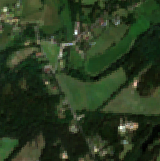

(-0.004491576420597608, 51.29829429964528)
Unnamed: 0_orig                                        2902
system:index                                         0_2902
SO2_column_number_density_orig                      31.9312
longitude                                       -0.00449158
latitude                                            51.2983
CH4_column_volume_mixing_ratio_dry_air_orig         25.2672
CO_column_number_density_orig                       30.7747
tropospheric_HCHO_column_number_density_orig        35.4321
tropospheric_NO2_column_number_density_orig         35.5797
O3_column_number_density_orig                       60.7514
Unnamed: 0_err                                         1321
CO_column_number_density_err                        69.2253
tropospheric_HCHO_column_number_density_err         57.3476
tropospheric_NO2_column_number_density_err         -35.5797
O3_column_number_density_err                        39.2486
SO2_column_number_density_err                       68.06

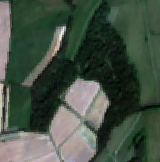

(-0.1751714804033067, 51.2623616882805)
Unnamed: 0_orig                                     2347
system:index                                      0_2347
SO2_column_number_density_orig                   34.2617
longitude                                      -0.175171
latitude                                         51.2624
CH4_column_volume_mixing_ratio_dry_air_orig      39.0979
CO_column_number_density_orig                    23.0457
tropospheric_HCHO_column_number_density_orig     55.7087
tropospheric_NO2_column_number_density_orig      36.8118
O3_column_number_density_orig                    68.0541
Unnamed: 0_err                                      1830
CO_column_number_density_err                     76.9543
tropospheric_HCHO_column_number_density_err     -55.7087
tropospheric_NO2_column_number_density_err      -36.8118
O3_column_number_density_err                     31.9459
SO2_column_number_density_err                    65.7383
CH4_column_volume_mixing_ratio_dry_air_err      

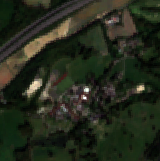

(-0.7141606508750197, 51.11863124282137)
Unnamed: 0_orig                                      143
system:index                                       0_143
SO2_column_number_density_orig                   49.1413
longitude                                      -0.714161
latitude                                         51.1186
CH4_column_volume_mixing_ratio_dry_air_orig      11.9789
CO_column_number_density_orig                    22.2477
tropospheric_HCHO_column_number_density_orig      51.787
tropospheric_NO2_column_number_density_orig      5.99188
O3_column_number_density_orig                    6.64049
Unnamed: 0_err                                       620
CO_column_number_density_err                      22.365
tropospheric_HCHO_column_number_density_err     -4.86347
tropospheric_NO2_column_number_density_err       45.0384
O3_column_number_density_err                     63.9125
SO2_column_number_density_err                   -18.3676
CH4_column_volume_mixing_ratio_dry_air_err     

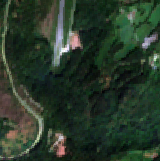

(-0.7950090264457765, 51.11863124282137)
Unnamed: 0_orig                                      134
system:index                                       0_134
SO2_column_number_density_orig                   37.0596
longitude                                      -0.795009
latitude                                         51.1186
CH4_column_volume_mixing_ratio_dry_air_orig      19.6075
CO_column_number_density_orig                    33.3774
tropospheric_HCHO_column_number_density_orig     6.60335
tropospheric_NO2_column_number_density_orig        4.773
O3_column_number_density_orig                    15.3883
Unnamed: 0_err                                       612
CO_column_number_density_err                     5.96812
tropospheric_HCHO_column_number_density_err      40.2895
tropospheric_NO2_column_number_density_err       24.3453
O3_column_number_density_err                     31.9208
SO2_column_number_density_err                    16.8829
CH4_column_volume_mixing_ratio_dry_air_err     

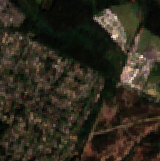

(-0.0583904934677689, 51.307277452486474)
Unnamed: 0_orig                                      3030
system:index                                       0_3030
SO2_column_number_density_orig                     27.386
longitude                                      -0.0583905
latitude                                          51.3073
CH4_column_volume_mixing_ratio_dry_air_orig       25.3489
CO_column_number_density_orig                     32.2387
tropospheric_HCHO_column_number_density_orig      24.4353
tropospheric_NO2_column_number_density_orig       40.4531
O3_column_number_density_orig                     63.4169
Unnamed: 0_err                                       1422
CO_column_number_density_err                      26.6023
tropospheric_HCHO_column_number_density_err       27.7716
tropospheric_NO2_column_number_density_err        22.3096
O3_column_number_density_err                      11.2853
SO2_column_number_density_err                     14.9692
CH4_column_volume_mixing_ratio

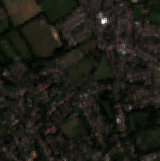

(-0.15720517472091627, 51.11863124282137)
Unnamed: 0_orig                                      205
system:index                                       0_205
SO2_column_number_density_orig                    24.467
longitude                                      -0.157205
latitude                                         51.1186
CH4_column_volume_mixing_ratio_dry_air_orig      63.4013
CO_column_number_density_orig                    24.7283
tropospheric_HCHO_column_number_density_orig     30.8696
tropospheric_NO2_column_number_density_orig       15.216
O3_column_number_density_orig                    55.1805
Unnamed: 0_err                                       666
CO_column_number_density_err                     33.6415
tropospheric_HCHO_column_number_density_err      22.3135
tropospheric_NO2_column_number_density_err       50.6351
O3_column_number_density_err                     17.5613
SO2_column_number_density_err                    17.5735
CH4_column_volume_mixing_ratio_dry_air_err    

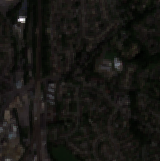

(-0.1661883275621115, 51.11863124282137)
Unnamed: 0_orig                                      204
system:index                                       0_204
SO2_column_number_density_orig                   22.2348
longitude                                      -0.166188
latitude                                         51.1186
CH4_column_volume_mixing_ratio_dry_air_orig      62.6633
CO_column_number_density_orig                    27.4721
tropospheric_HCHO_column_number_density_orig     32.6094
tropospheric_NO2_column_number_density_orig      15.7153
O3_column_number_density_orig                     58.376
Unnamed: 0_err                                       667
CO_column_number_density_err                     32.2198
tropospheric_HCHO_column_number_density_err        20.18
tropospheric_NO2_column_number_density_err       49.7802
O3_column_number_density_err                     15.4574
SO2_column_number_density_err                     19.558
CH4_column_volume_mixing_ratio_dry_air_err     

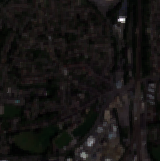

(-0.7411101093986052, 51.11863124282137)
Unnamed: 0_orig                                     140
system:index                                      0_140
SO2_column_number_density_orig                  49.1688
longitude                                      -0.74111
latitude                                        51.1186
CH4_column_volume_mixing_ratio_dry_air_orig     13.6664
CO_column_number_density_orig                   25.6878
tropospheric_HCHO_column_number_density_orig    21.6724
tropospheric_NO2_column_number_density_orig      5.5096
O3_column_number_density_orig                         0
Unnamed: 0_err                                      618
CO_column_number_density_err                    9.68457
tropospheric_HCHO_column_number_density_err      25.516
tropospheric_NO2_column_number_density_err      21.8448
O3_column_number_density_err                    43.8081
SO2_column_number_density_err                   7.36539
CH4_column_volume_mixing_ratio_dry_air_err      14.5968
CO_colu

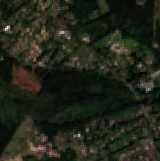

(-0.7500932622398004, 51.11863124282137)
Unnamed: 0_orig                                      139
system:index                                       0_139
SO2_column_number_density_orig                   48.3756
longitude                                      -0.750093
latitude                                         51.1186
CH4_column_volume_mixing_ratio_dry_air_orig        13.26
CO_column_number_density_orig                    29.7579
tropospheric_HCHO_column_number_density_orig     9.12034
tropospheric_NO2_column_number_density_orig      3.25039
O3_column_number_density_orig                    4.01968
Unnamed: 0_err                                       617
CO_column_number_density_err                     4.43002
tropospheric_HCHO_column_number_density_err      36.8802
tropospheric_NO2_column_number_density_err       21.3258
O3_column_number_density_err                     36.8672
SO2_column_number_density_err                    9.52395
CH4_column_volume_mixing_ratio_dry_air_err     

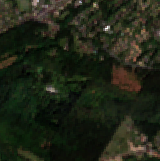

In [116]:
# Show largest overpredictors 
for idx, row in combi_df.nlargest(10, ['errsum']).iterrows():
  coords = (row[c.lon], row[c.lat])
  print(coords)
  print(row)
  img_path = fyputil.getFilepath(coords)
  display(Image.open(img_path))

(-0.004491576420597608, 51.37914267521604)
Unnamed: 0_orig                                       4108
system:index                                        0_4108
SO2_column_number_density_orig                     17.4044
longitude                                      -0.00449158
latitude                                           51.3791
CH4_column_volume_mixing_ratio_dry_air_orig        37.6602
CO_column_number_density_orig                      85.2142
tropospheric_HCHO_column_number_density_orig       82.3769
tropospheric_NO2_column_number_density_orig        70.9914
O3_column_number_density_orig                      80.7646
Unnamed: 0_err                                         379
CO_column_number_density_err                      -85.2142
tropospheric_HCHO_column_number_density_err       -82.3769
tropospheric_NO2_column_number_density_err        -70.9914
O3_column_number_density_err                       19.2354
SO2_column_number_density_err                      82.5956
CH4_column_vo

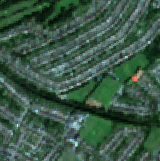

(0.03144103494418325, 51.37015952237484)
Unnamed: 0_orig                                     3978
system:index                                      0_3978
SO2_column_number_density_orig                   37.2574
longitude                                       0.031441
latitude                                         51.3702
CH4_column_volume_mixing_ratio_dry_air_orig      47.1185
CO_column_number_density_orig                     82.035
tropospheric_HCHO_column_number_density_orig     75.8536
tropospheric_NO2_column_number_density_orig      75.8784
O3_column_number_density_orig                    89.5983
Unnamed: 0_err                                       279
CO_column_number_density_err                    -39.9825
tropospheric_HCHO_column_number_density_err     -27.6585
tropospheric_NO2_column_number_density_err      -40.0005
O3_column_number_density_err                    -29.8083
SO2_column_number_density_err                    11.8056
CH4_column_volume_mixing_ratio_dry_air_err     

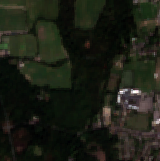

(0.13025571619733062, 51.20846277123333)
Unnamed: 0_orig                                        1577
system:index                                         0_1577
SO2_column_number_density_orig                      61.0009
longitude                                          0.130256
latitude                                            51.2085
CH4_column_volume_mixing_ratio_dry_air_orig         55.7713
CO_column_number_density_orig                       65.6851
tropospheric_HCHO_column_number_density_orig        46.2166
tropospheric_NO2_column_number_density_orig         33.2483
O3_column_number_density_orig                        70.635
Unnamed: 0_err                                          882
CO_column_number_density_err                       -65.6851
tropospheric_HCHO_column_number_density_err        -46.2166
tropospheric_NO2_column_number_density_err         -33.2483
O3_column_number_density_err                         29.365
SO2_column_number_density_err                       38.9991

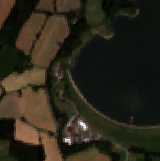

(-0.229070397450478, 51.361176369533645)
Unnamed: 0_orig                                    3815
system:index                                     0_3815
SO2_column_number_density_orig                  51.7357
longitude                                      -0.22907
latitude                                        51.3612
CH4_column_volume_mixing_ratio_dry_air_orig     88.6337
CO_column_number_density_orig                   81.8368
tropospheric_HCHO_column_number_density_orig    48.2262
tropospheric_NO2_column_number_density_orig      81.223
O3_column_number_density_orig                   87.7763
Unnamed: 0_err                                      149
CO_column_number_density_err                   -30.9164
tropospheric_HCHO_column_number_density_err     1.03521
tropospheric_NO2_column_number_density_err     -28.3895
O3_column_number_density_err                   -16.3504
SO2_column_number_density_err                  -10.5749
CH4_column_volume_mixing_ratio_dry_air_err     -44.2284
CO_colu

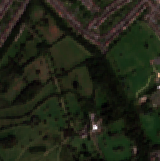

(0.04940734062657368, 51.2533785354393)
Unnamed: 0_orig                                        2238
system:index                                         0_2238
SO2_column_number_density_orig                      63.1825
longitude                                         0.0494073
latitude                                            51.2534
CH4_column_volume_mixing_ratio_dry_air_orig         47.3198
CO_column_number_density_orig                       42.1091
tropospheric_HCHO_column_number_density_orig        81.5591
tropospheric_NO2_column_number_density_orig         30.7653
O3_column_number_density_orig                       60.3694
Unnamed: 0_err                                         1190
CO_column_number_density_err                       -42.1091
tropospheric_HCHO_column_number_density_err        -81.5591
tropospheric_NO2_column_number_density_err         -30.7653
O3_column_number_density_err                        39.6306
SO2_column_number_density_err                       36.8175


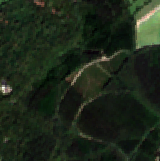

(-0.35483453722721103, 51.37015952237484)
Unnamed: 0_orig                                     3935
system:index                                      0_3935
SO2_column_number_density_orig                   44.6484
longitude                                      -0.354835
latitude                                         51.3702
CH4_column_volume_mixing_ratio_dry_air_orig      80.8229
CO_column_number_density_orig                    72.8644
tropospheric_HCHO_column_number_density_orig      52.472
tropospheric_NO2_column_number_density_orig      86.9117
O3_column_number_density_orig                    94.5773
Unnamed: 0_err                                       245
CO_column_number_density_err                    -20.8206
tropospheric_HCHO_column_number_density_err     -4.05736
tropospheric_NO2_column_number_density_err      -38.6923
O3_column_number_density_err                    -24.9814
SO2_column_number_density_err                  -0.636802
CH4_column_volume_mixing_ratio_dry_air_err    

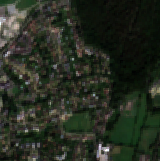

(0.13025571619733062, 51.37914267521604)
Unnamed: 0_orig                                     4123
system:index                                      0_4123
SO2_column_number_density_orig                   57.1137
longitude                                       0.130256
latitude                                         51.3791
CH4_column_volume_mixing_ratio_dry_air_orig      74.0891
CO_column_number_density_orig                    71.5855
tropospheric_HCHO_column_number_density_orig     57.0633
tropospheric_NO2_column_number_density_orig      71.1059
O3_column_number_density_orig                    76.7995
Unnamed: 0_err                                       393
CO_column_number_density_err                    -19.5236
tropospheric_HCHO_column_number_density_err     -14.1653
tropospheric_NO2_column_number_density_err      -38.0741
O3_column_number_density_err                    -8.73804
SO2_column_number_density_err                   -15.1799
CH4_column_volume_mixing_ratio_dry_air_err     

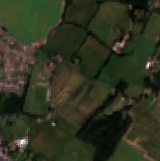

(-0.3458513843860158, 51.37015952237484)
Unnamed: 0_orig                                     3936
system:index                                      0_3936
SO2_column_number_density_orig                   44.5903
longitude                                      -0.345851
latitude                                         51.3702
CH4_column_volume_mixing_ratio_dry_air_orig      75.5597
CO_column_number_density_orig                    78.7942
tropospheric_HCHO_column_number_density_orig     56.7406
tropospheric_NO2_column_number_density_orig      88.3847
O3_column_number_density_orig                    91.5352
Unnamed: 0_err                                       244
CO_column_number_density_err                    -26.3117
tropospheric_HCHO_column_number_density_err      -7.9374
tropospheric_NO2_column_number_density_err      -34.5389
O3_column_number_density_err                      -18.98
SO2_column_number_density_err                   -3.02695
CH4_column_volume_mixing_ratio_dry_air_err     

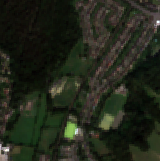

(0.06737364630896411, 51.34321006385125)
Unnamed: 0_orig                                        3580
system:index                                         0_3580
SO2_column_number_density_orig                      48.9004
longitude                                         0.0673736
latitude                                            51.3432
CH4_column_volume_mixing_ratio_dry_air_orig          45.067
CO_column_number_density_orig                       60.7917
tropospheric_HCHO_column_number_density_orig        22.0199
tropospheric_NO2_column_number_density_orig         55.6829
O3_column_number_density_orig                       83.2808
Unnamed: 0_err                                           76
CO_column_number_density_err                       -60.7917
tropospheric_HCHO_column_number_density_err        -22.0199
tropospheric_NO2_column_number_density_err         -55.6829
O3_column_number_density_err                        16.7192
SO2_column_number_density_err                       51.0996

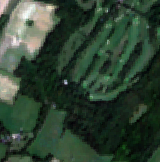

(-0.19313778608569712, 51.37914267521604)
Unnamed: 0_orig                                     4087
system:index                                      0_4087
SO2_column_number_density_orig                   30.3006
longitude                                      -0.193138
latitude                                         51.3791
CH4_column_volume_mixing_ratio_dry_air_orig      93.2622
CO_column_number_density_orig                     89.554
tropospheric_HCHO_column_number_density_orig     66.0841
tropospheric_NO2_column_number_density_orig      94.4949
O3_column_number_density_orig                    89.8003
Unnamed: 0_err                                       360
CO_column_number_density_err                    -26.6066
tropospheric_HCHO_column_number_density_err     -16.5939
tropospheric_NO2_column_number_density_err      -33.5932
O3_column_number_density_err                    -9.27045
SO2_column_number_density_err                    8.20807
CH4_column_volume_mixing_ratio_dry_air_err    

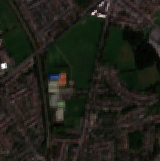

In [117]:
# show underpredictors
for idx, row in combi_df.nsmallest(10, ['errsum']).iterrows():
  coords = (row[c.lon], row[c.lat])
  print(coords)
  print(row)
  img_path = fyputil.getFilepath(coords)
  display(Image.open(img_path))

(-0.2919524673388445, 51.19947961839213)
Unnamed: 0_orig                                     1396
system:index                                      0_1396
SO2_column_number_density_orig                   43.0897
longitude                                      -0.291952
latitude                                         51.1995
CH4_column_volume_mixing_ratio_dry_air_orig      48.1476
CO_column_number_density_orig                    37.3263
tropospheric_HCHO_column_number_density_orig     43.0464
tropospheric_NO2_column_number_density_orig      20.0815
O3_column_number_density_orig                    58.0941
Unnamed: 0_err                                      1710
CO_column_number_density_err                     1.19606
tropospheric_HCHO_column_number_density_err     0.528057
tropospheric_NO2_column_number_density_err       1.00869
O3_column_number_density_err                     2.25221
SO2_column_number_density_err                    2.06044
CH4_column_volume_mixing_ratio_dry_air_err     

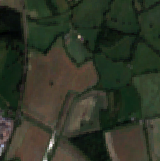

(0.1122894105149402, 51.20846277123333)
Unnamed: 0_orig                                     1575
system:index                                      0_1575
SO2_column_number_density_orig                   45.7476
longitude                                       0.112289
latitude                                         51.2085
CH4_column_volume_mixing_ratio_dry_air_orig      52.1553
CO_column_number_density_orig                    58.7438
tropospheric_HCHO_column_number_density_orig     47.5145
tropospheric_NO2_column_number_density_orig      28.9456
O3_column_number_density_orig                    69.7695
Unnamed: 0_err                                       881
CO_column_number_density_err                    -4.81203
tropospheric_HCHO_column_number_density_err     -3.68643
tropospheric_NO2_column_number_density_err        -1.017
O3_column_number_density_err                    -4.98131
SO2_column_number_density_err                    1.49002
CH4_column_volume_mixing_ratio_dry_air_err     -

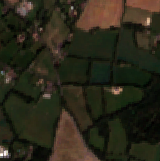

(0.2919524673388445, 51.31626060532767)
Unnamed: 0_orig                                     3203
system:index                                      0_3203
SO2_column_number_density_orig                   39.5125
longitude                                       0.291952
latitude                                         51.3163
CH4_column_volume_mixing_ratio_dry_air_orig      51.1342
CO_column_number_density_orig                    53.7714
tropospheric_HCHO_column_number_density_orig     47.8097
tropospheric_NO2_column_number_density_orig      37.5831
O3_column_number_density_orig                     75.187
Unnamed: 0_err                                      1559
CO_column_number_density_err                     1.95554
tropospheric_HCHO_column_number_density_err     -2.09793
tropospheric_NO2_column_number_density_err      -2.42554
O3_column_number_density_err                    -2.81855
SO2_column_number_density_err                    6.03391
CH4_column_volume_mixing_ratio_dry_air_err      

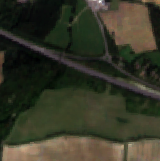

(-0.4087334542743823, 51.29829429964528)
Unnamed: 0_orig                                      2857
system:index                                       0_2857
SO2_column_number_density_orig                    44.9657
longitude                                       -0.408733
latitude                                          51.2983
CH4_column_volume_mixing_ratio_dry_air_orig       37.4683
CO_column_number_density_orig                     42.3881
tropospheric_HCHO_column_number_density_orig       45.433
tropospheric_NO2_column_number_density_orig       39.7307
O3_column_number_density_orig                     68.1681
Unnamed: 0_err                                       1288
CO_column_number_density_err                      3.63377
tropospheric_HCHO_column_number_density_err     0.0141291
tropospheric_NO2_column_number_density_err       -7.00671
O3_column_number_density_err                   -0.0662553
SO2_column_number_density_err                    -1.99506
CH4_column_volume_mixing_ratio_

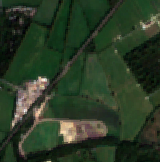

(-0.10330625767374498, 51.226429076915714)
Unnamed: 0_orig                                     1819
system:index                                      0_1819
SO2_column_number_density_orig                   29.8378
longitude                                      -0.103306
latitude                                         51.2264
CH4_column_volume_mixing_ratio_dry_air_orig      48.1607
CO_column_number_density_orig                    52.5891
tropospheric_HCHO_column_number_density_orig     43.4434
tropospheric_NO2_column_number_density_orig      29.6222
O3_column_number_density_orig                    67.8208
Unnamed: 0_err                                       965
CO_column_number_density_err                    -2.01279
tropospheric_HCHO_column_number_density_err      1.73156
tropospheric_NO2_column_number_density_err      0.192123
O3_column_number_density_err                   -0.994754
SO2_column_number_density_err                    13.7962
CH4_column_volume_mixing_ratio_dry_air_err   

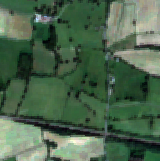

(0.1122894105149402, 51.32524375816886)
Unnamed: 0_orig                                     3317
system:index                                      0_3317
SO2_column_number_density_orig                   37.9509
longitude                                       0.112289
latitude                                         51.3252
CH4_column_volume_mixing_ratio_dry_air_orig      40.3116
CO_column_number_density_orig                    45.7672
tropospheric_HCHO_column_number_density_orig       43.56
tropospheric_NO2_column_number_density_orig      40.2904
O3_column_number_density_orig                    75.4694
Unnamed: 0_err                                      1651
CO_column_number_density_err                     1.11954
tropospheric_HCHO_column_number_density_err      1.72787
tropospheric_NO2_column_number_density_err      -3.27474
O3_column_number_density_err                      -7.279
SO2_column_number_density_err                    3.35358
CH4_column_volume_mixing_ratio_dry_air_err      

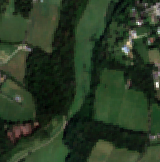

(-0.3009356201800397, 51.20846277123333)
Unnamed: 0_orig                                      1529
system:index                                       0_1529
SO2_column_number_density_orig                    49.2952
longitude                                       -0.300936
latitude                                          51.2085
CH4_column_volume_mixing_ratio_dry_air_orig       44.2578
CO_column_number_density_orig                     38.9701
tropospheric_HCHO_column_number_density_orig      51.5082
tropospheric_NO2_column_number_density_orig       19.2389
O3_column_number_density_orig                     59.5225
Unnamed: 0_err                                        843
CO_column_number_density_err                    0.0901922
tropospheric_HCHO_column_number_density_err      -9.03747
tropospheric_NO2_column_number_density_err      -0.764798
O3_column_number_density_err                     -4.57774
SO2_column_number_density_err                    -3.58624
CH4_column_volume_mixing_ratio_

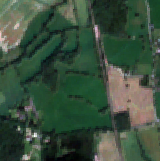

(0.3278850787036254, 51.307277452486474)
Unnamed: 0_orig                                     3073
system:index                                      0_3073
SO2_column_number_density_orig                   41.1766
longitude                                       0.327885
latitude                                         51.3073
CH4_column_volume_mixing_ratio_dry_air_orig      58.8401
CO_column_number_density_orig                     58.711
tropospheric_HCHO_column_number_density_orig     47.3513
tropospheric_NO2_column_number_density_orig      40.5069
O3_column_number_density_orig                    80.7615
Unnamed: 0_err                                      1463
CO_column_number_density_err                     6.47404
tropospheric_HCHO_column_number_density_err     -2.08332
tropospheric_NO2_column_number_density_err      -1.31595
O3_column_number_density_err                    -4.72898
SO2_column_number_density_err                    5.04357
CH4_column_volume_mixing_ratio_dry_air_err     

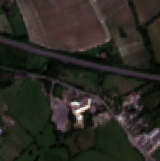

(0.3368682315448206, 51.307277452486474)
Unnamed: 0_orig                                     3074
system:index                                      0_3074
SO2_column_number_density_orig                   39.1282
longitude                                       0.336868
latitude                                         51.3073
CH4_column_volume_mixing_ratio_dry_air_orig      57.6195
CO_column_number_density_orig                    61.6656
tropospheric_HCHO_column_number_density_orig     44.2825
tropospheric_NO2_column_number_density_orig      40.9249
O3_column_number_density_orig                    79.4133
Unnamed: 0_err                                      1457
CO_column_number_density_err                     4.64315
tropospheric_HCHO_column_number_density_err      2.03371
tropospheric_NO2_column_number_density_err      -2.16505
O3_column_number_density_err                    -2.92029
SO2_column_number_density_err                    7.96331
CH4_column_volume_mixing_ratio_dry_air_err     

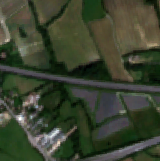

(-0.2919524673388445, 51.2623616882805)
Unnamed: 0_orig                                     2334
system:index                                      0_2334
SO2_column_number_density_orig                   38.3045
longitude                                      -0.291952
latitude                                         51.2624
CH4_column_volume_mixing_ratio_dry_air_orig      30.8487
CO_column_number_density_orig                    29.1188
tropospheric_HCHO_column_number_density_orig     46.0769
tropospheric_NO2_column_number_density_orig      29.1731
O3_column_number_density_orig                    66.5154
Unnamed: 0_err                                      1825
CO_column_number_density_err                     4.71578
tropospheric_HCHO_column_number_density_err    -0.948721
tropospheric_NO2_column_number_density_err       1.01273
O3_column_number_density_err                    -7.47313
SO2_column_number_density_err                    4.82752
CH4_column_volume_mixing_ratio_dry_air_err      

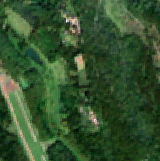

In [118]:
# show underpredictors
for idx, row in combi_df.nsmallest(10, ['errabs']).iterrows():
  coords = (row[c.lon], row[c.lat])
  print(coords)
  print(row)
  img_path = fyputil.getFilepath(coords)
  display(Image.open(img_path))

### Sample images vs predictions 
what regions are easier to predict than others? 

create accuracy heatmap 

(-0.004491576420597608, 51.29829429964528)
Unnamed: 0_orig                                        2902
system:index                                         0_2902
SO2_column_number_density_orig                      31.9312
longitude                                       -0.00449158
latitude                                            51.2983
CH4_column_volume_mixing_ratio_dry_air_orig         25.2672
CO_column_number_density_orig                       30.7747
tropospheric_HCHO_column_number_density_orig        35.4321
tropospheric_NO2_column_number_density_orig         35.5797
O3_column_number_density_orig                       60.7514
Unnamed: 0_err                                         1321
CO_column_number_density_err                        69.2253
tropospheric_HCHO_column_number_density_err         57.3476
tropospheric_NO2_column_number_density_err         -35.5797
O3_column_number_density_err                        39.2486
SO2_column_number_density_err                       68.06

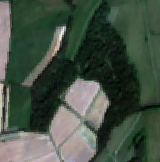

(0.04940734062657368, 51.32524375816886)
Unnamed: 0_orig                                        3310
system:index                                         0_3310
SO2_column_number_density_orig                      37.9731
longitude                                         0.0494073
latitude                                            51.3252
CH4_column_volume_mixing_ratio_dry_air_orig         44.9987
CO_column_number_density_orig                       50.3184
tropospheric_HCHO_column_number_density_orig        5.89156
tropospheric_NO2_column_number_density_orig         47.0119
O3_column_number_density_orig                       68.4381
Unnamed: 0_err                                         1644
CO_column_number_density_err                       -50.3184
tropospheric_HCHO_column_number_density_err        -5.89156
tropospheric_NO2_column_number_density_err         -47.0119
O3_column_number_density_err                        31.5619
SO2_column_number_density_err                       62.0269

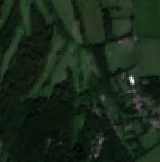

(-0.1841546332445019, 51.2533785354393)
Unnamed: 0_orig                                     2212
system:index                                      0_2212
SO2_column_number_density_orig                   26.9011
longitude                                      -0.184155
latitude                                         51.2534
CH4_column_volume_mixing_ratio_dry_air_orig      43.0981
CO_column_number_density_orig                    28.4005
tropospheric_HCHO_column_number_density_orig     71.6973
tropospheric_NO2_column_number_density_orig      35.3834
O3_column_number_density_orig                    62.5903
Unnamed: 0_err                                      1166
CO_column_number_density_err                     71.1208
tropospheric_HCHO_column_number_density_err     -37.4862
tropospheric_NO2_column_number_density_err      -34.9319
O3_column_number_density_err                     37.1076
SO2_column_number_density_err                    55.1726
CH4_column_volume_mixing_ratio_dry_air_err      

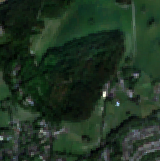

(0.35483453722721103, 51.29829429964528)
Unnamed: 0_orig                                        2942
system:index                                         0_2942
SO2_column_number_density_orig                      48.1624
longitude                                          0.354835
latitude                                            51.2983
CH4_column_volume_mixing_ratio_dry_air_orig         65.7371
CO_column_number_density_orig                       66.0545
tropospheric_HCHO_column_number_density_orig        16.8609
tropospheric_NO2_column_number_density_orig         46.6633
O3_column_number_density_orig                       75.7339
Unnamed: 0_err                                         1355
CO_column_number_density_err                        33.9455
tropospheric_HCHO_column_number_density_err          71.959
tropospheric_NO2_column_number_density_err         -46.6633
O3_column_number_density_err                        24.2661
SO2_column_number_density_err                       51.8365

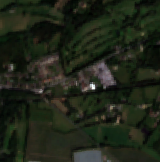

(-0.31890192586243016, 51.19947961839213)
Unnamed: 0_orig                                        1393
system:index                                         0_1393
SO2_column_number_density_orig                        48.67
longitude                                         -0.318902
latitude                                            51.1995
CH4_column_volume_mixing_ratio_dry_air_orig         48.4445
CO_column_number_density_orig                       25.7053
tropospheric_HCHO_column_number_density_orig        54.8822
tropospheric_NO2_column_number_density_orig         16.1729
O3_column_number_density_orig                       53.8957
Unnamed: 0_err                                         1708
CO_column_number_density_err                       -25.7053
tropospheric_HCHO_column_number_density_err        -54.8822
tropospheric_NO2_column_number_density_err         -16.1729
O3_column_number_density_err                        46.1043
SO2_column_number_density_err                         51.3

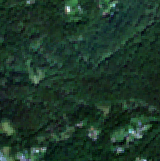

(-0.7500932622398004, 51.18151331270974)
Unnamed: 0_orig                                        1077
system:index                                         0_1077
SO2_column_number_density_orig                      49.6954
longitude                                         -0.750093
latitude                                            51.1815
CH4_column_volume_mixing_ratio_dry_air_orig         30.9908
CO_column_number_density_orig                       40.8365
tropospheric_HCHO_column_number_density_orig        47.9716
tropospheric_NO2_column_number_density_orig         11.4296
O3_column_number_density_orig                       24.5092
Unnamed: 0_err                                          420
CO_column_number_density_err                        59.1635
tropospheric_HCHO_column_number_density_err         42.8066
tropospheric_NO2_column_number_density_err         -11.4296
O3_column_number_density_err                        75.4908
SO2_column_number_density_err                       50.3044

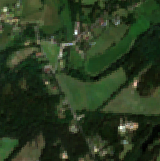

(0.06737364630896411, 51.29829429964528)
Unnamed: 0_orig                                      2910
system:index                                       0_2910
SO2_column_number_density_orig                    1.37409
longitude                                       0.0673736
latitude                                          51.2983
CH4_column_volume_mixing_ratio_dry_air_orig       49.9448
CO_column_number_density_orig                     40.4707
tropospheric_HCHO_column_number_density_orig      49.9786
tropospheric_NO2_column_number_density_orig        40.882
O3_column_number_density_orig                     70.0552
Unnamed: 0_err                                       1330
CO_column_number_density_err                     -4.18048
tropospheric_HCHO_column_number_density_err      -5.69092
tropospheric_NO2_column_number_density_err       -19.1769
O3_column_number_density_err                     -9.84114
SO2_column_number_density_err                     42.9272
CH4_column_volume_mixing_ratio_

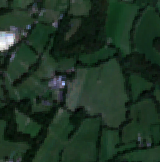

In [109]:
# Show outliers 
for idx, row in combi_df.nlargest(20, [f"{c.SO2_band}_err"]).iterrows():
  if row[f"{c.SO2_band}_pred"] in [0, 100]: continue
  coords = (row[c.lon], row[c.lat])
  print(coords)
  print(row)
  img_path = fyputil.getFilepath(coords)
  display(Image.open(img_path))

## Brunel Analysis 